In [1]:
import pandas as pd
import numpy as np
import random
from random import shuffle
random.seed(18)
import re
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
# from nltk import word_tokenize
from sklearn.metrics import roc_auc_score
from nltk import word_tokenize,pos_tag
from textblob import TextBlob
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import stem
import csv
from sklearn.metrics import f1_score
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
pd.set_option('display.max_colwidth', None)

seed = 18


In [2]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [3]:
# from pycorenlp import StanfordCoreNLP
# nlp = StanfordCoreNLP('http://localhost:9000')

import stanza
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline

2024-07-17 20:20:55 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-07-17 20:20:55 INFO: Downloading default packages for language: en (English) ...
2024-07-17 20:20:57 INFO: File exists: /Users/gbaldonado/stanza_resources/en/default.zip
2024-07-17 20:21:00 INFO: Finished downloading models and saved to /Users/gbaldonado/stanza_resources
2024-07-17 20:21:00 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-07-17 20:21:00 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-07-17 20:21:01 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-07-17 20:21:01 INFO: Using device: cpu
2024-07-17 20:21:01 INFO: Loading: tokenize
2024-07-17 20:21:02 INFO: Loading: mwt
2024-07-17 20:21:02 INFO: Loading: pos
2024-07-17 20:21:02 INFO: Loading: lemma
2024-07-17 20:21:02 INFO: Loading: constituency
2024-07-17 20:21:02 INFO: Loading: depparse
2024-07-17 20:21:03 INFO: Loading: sentiment
2024-07-17 20:21:03 INFO: Loading: 

In [4]:
attainment_df = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/single_theme_using_jaccard_method/Attainment_sentence_level_batch_1_jaccard.csv")
aspirational_df = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/single_theme_using_jaccard_method/Aspirational_sentence_level_batch_1_jaccard.csv")

print(attainment_df.shape, aspirational_df.shape)

(1668, 3) (3036, 3)


## Method 1: Shuffling merged, then stratify

For comparison:
### Model 1 LR with original data, no shuffling, no resampling (baseline):
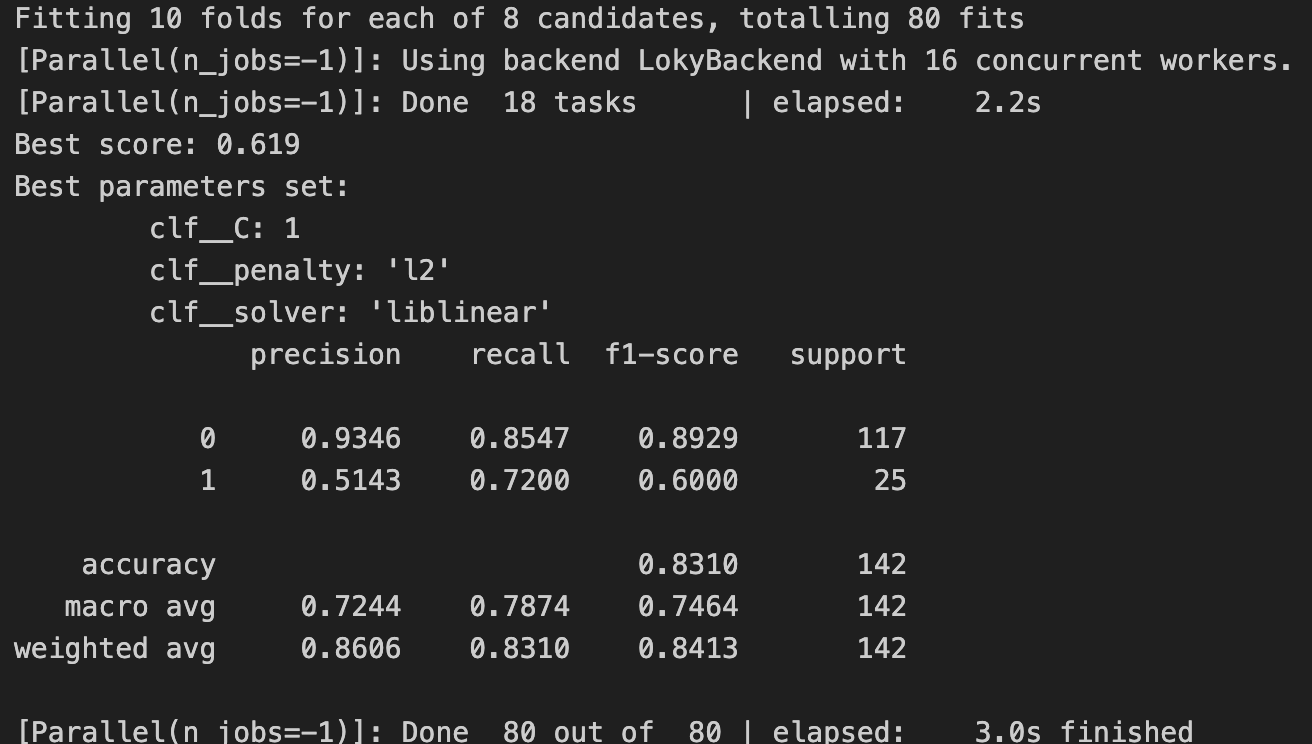

### Model 1 LR with merged data, no resampling
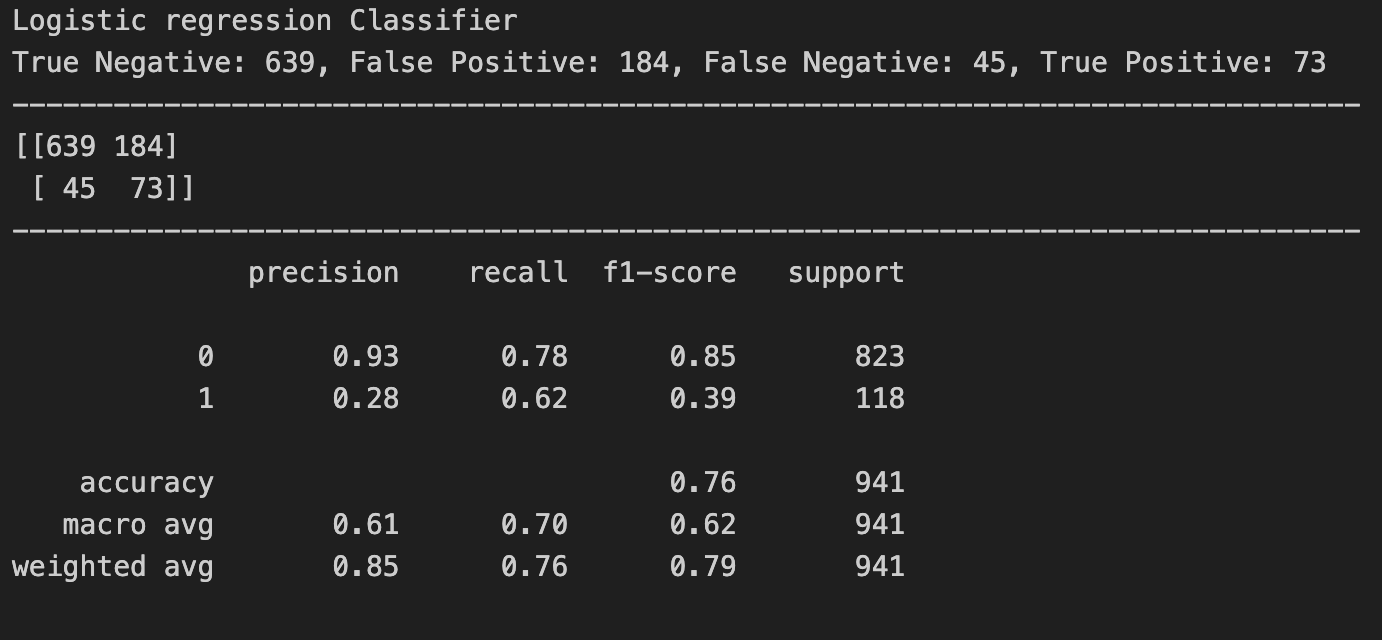


In [5]:
merged_aspirational_df = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/merged_themes_using_jaccard_method/merged_Aspirational_sentence_level_batch_1_jaccard.csv", encoding='utf-8')
merged_aspirational_df = shuffle(merged_aspirational_df, random_state=seed)
training_df, test_df = train_test_split(merged_aspirational_df, test_size=0.2, random_state=seed, stratify=merged_aspirational_df['label'])
training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [6]:
merged_aspirational_df.shape

(4704, 3)

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

merged_aspirational_file_path = "/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/merged_themes_using_jaccard_method/merged_Aspirational_sentence_level_batch_1_jaccard.csv"

def balance_dataset(file_path, positive_percentage, random_state=42):
    try:
        # Load the dataset
        df = pd.read_csv(file_path, encoding='utf-8')

        # Split into training and test sets
        training_df, test_df = train_test_split(df, test_size=0.1, random_state=random_state, stratify=df['label'])
        training_df.reset_index(drop=True, inplace=True)
        test_df.reset_index(drop=True, inplace=True)

        # Separate positive and negative samples in training set
        positive_samples_train = training_df[training_df['label'] == 1]
        negative_samples_train = training_df[training_df['label'] == 0]

        # Calculate the desired number of negative samples for training set
        num_positive_train = len(positive_samples_train)
        desired_negative_count_train = int(num_positive_train / positive_percentage) - num_positive_train

        # Check if we have enough negative samples for training set
        if desired_negative_count_train > len(negative_samples_train):
            raise ValueError("Not enough negative samples to achieve the desired positive ratio in the training set.")

        # Undersample negative samples in training set
        negative_samples_undersampled_train = negative_samples_train.sample(n=desired_negative_count_train, random_state=random_state)

        # Combine the undersampled negative samples with positive samples for training set
        balanced_training_df = pd.concat([positive_samples_train, negative_samples_undersampled_train]).reset_index(drop=True)

        # Shuffle the combined DataFrame for training set
        balanced_training_df = balanced_training_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

        # Separate positive and negative samples in test set
        positive_samples_test = test_df[test_df['label'] == 1]
        negative_samples_test = test_df[test_df['label'] == 0]

        # Calculate the desired number of negative samples for test set
        num_positive_test = len(positive_samples_test)
        desired_negative_count_test = int(num_positive_test / positive_percentage) - num_positive_test

        # Check if we have enough negative samples for test set
        if desired_negative_count_test > len(negative_samples_test):
            raise ValueError("Not enough negative samples to achieve the desired positive ratio in the test set.")

        # Undersample negative samples in test set
        negative_samples_undersampled_test = negative_samples_test.sample(n=desired_negative_count_test, random_state=random_state)

        # Combine the undersampled negative samples with positive samples for test set
        balanced_test_df = pd.concat([positive_samples_test, negative_samples_undersampled_test]).reset_index(drop=True)

        # Shuffle the combined DataFrame for test set
        balanced_test_df = balanced_test_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

        print("Balanced training DataFrame:")
        print(balanced_training_df['label'].value_counts())

        print("Balanced test DataFrame:")
        print(balanced_test_df['label'].value_counts())

        return balanced_training_df, balanced_test_df

    except FileNotFoundError:
        print("Error: The file was not found. Please check the file path.")
    except ValueError as ve:
        print(f"ValueError: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage
training_df, test_df = balance_dataset(merged_aspirational_file_path, positive_percentage=0.20)
training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Balanced training DataFrame:
label
0    2116
1     529
Name: count, dtype: int64
Balanced test DataFrame:
label
0    236
1     59
Name: count, dtype: int64


In [8]:
test_df

,sentence,label,phrase
0,by taking this physics course it will allow me to take that extra step forward to achieve my goal.,0,"['I am here at San Francisco State to recieve a formal education and strive for my ba in computer science.', 'Although this course is simply a requirement I hope to learn something beneficial and change the way I think about things.']"
1,"even though i am not a huge fan of physics, i have to take it regardless.",0,['My goal is just to pass this course. I do not necessarily care about the grade I get as long as I pass.']
2,i have found physics to be very difficult and i am hoping this class will help me pass physics.,0,['I dont want to fail again and I also would like to understand it.']
3,"i know there will be some topics i wont understand or have struggles on, but i want to utilize the provided resources on campus such as tutoring and attending office hours to visit the professor in discussion about my class grade standing.",0,['I chose to be in this class because it is a requirement to fulfill in order for me to obtain my Cell and Molecular Biology bachelors degree.']
4,i believe that knowing a little bit of every subject in college is what makes the graduates ready to face life with a good foundation of experiences.,0,"[""Commuting to San Francisco every day from San Mateo is a little bit costly, so hopefully I'll be able to find a good apartment closeby, and maybe find good internships that relate to my major to help me get a good start in my career after I graduate.""]"
...,...,...,...
290,i think i will enjoy this semester a lot more due to the fact that theres more of an appeal to me.,0,['I very much do look forward to learning about the type of physics we cant see much of and learning how this is applicable to everyday life.']
291,i feel like i am meant to be here.,0,['I am trying to graduate before the age of 30']
292,"i did okay on the first quiz, but that was because i prepared earlier.",0,['I really want to be a video gamer programmer and I know that physics is really important in that industry because of animation etc']
293,i also want to learn more about physics on how the subject relates to the world around us.,0,['I took physics in high school and I learned a lot then and I just want to keep learning and get a better inside of the subject itself']


In [9]:
training_df.head()

,sentence,label,phrase
0,i have no specific direction in my life other than the general goal i have always had since i knew how to talk.,0,"['I am here because I want to do better in my OCHEM class.', 'I want to learn new things that are outside of my comfort zone.']"
1,being here has many different meanings and perspectives.,0,"['I am here in this class to get my degree, but I am here at this school to better my life.']"
2,"i am intrigued by this career because i grew up with family who died due to heart conditions, therefore i want to be able to understand and form conclusions on my own that way i can comprehend the cause of their deaths.",0,['a degree in Cell and Molecular Biology']
3,"higher education for me is a segway into the job field, without it would make getting a job in the future that much more difficult.",0,['All of this has lead me to pursue a degree in Mechanical Engineering']
4,"physics 2 is difficult but instead of giving up like before, my attitude includes ambition and determination.",0,['The real reason I am actually here is to learn how to be a better physical therapist in the future by understanding the foundations of biomechanics through physics.']


In [10]:
pos_labels = len([n for n in training_df['label'] if n==1])
print("Positive labels present in the dataset : {}  out of {} or {}%".format(pos_labels, len(training_df['label']), (pos_labels/len(training_df['label']))*100))

Positive labels present in the dataset : 529  out of 2645 or 20.0%


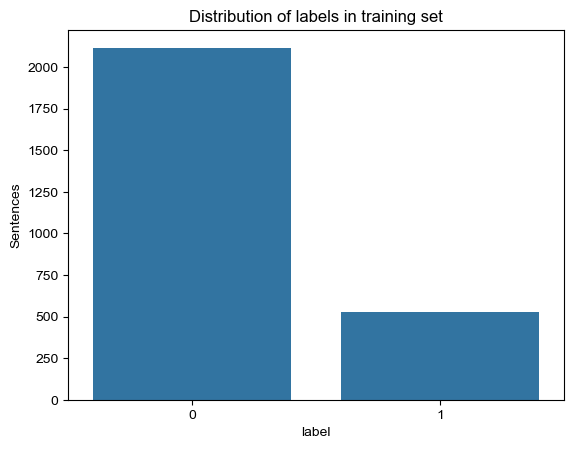

In [11]:
x = training_df['label'].value_counts()
sns.barplot(x)
sns.set(style="whitegrid")
plt.title('Distribution of labels in training set')
plt.gca().set_ylabel('Sentences')
plt.show()

In [12]:
test_df.shape

(295, 3)

In [14]:
test_df.head()

,sentence,label,phrase
0,by taking this physics course it will allow me to take that extra step forward to achieve my goal.,0,"['I am here at San Francisco State to recieve a formal education and strive for my ba in computer science.', 'Although this course is simply a requirement I hope to learn something beneficial and change the way I think about things.']"
1,"even though i am not a huge fan of physics, i have to take it regardless.",0,['My goal is just to pass this course. I do not necessarily care about the grade I get as long as I pass.']
2,i have found physics to be very difficult and i am hoping this class will help me pass physics.,0,['I dont want to fail again and I also would like to understand it.']
3,"i know there will be some topics i wont understand or have struggles on, but i want to utilize the provided resources on campus such as tutoring and attending office hours to visit the professor in discussion about my class grade standing.",0,['I chose to be in this class because it is a requirement to fulfill in order for me to obtain my Cell and Molecular Biology bachelors degree.']
4,i believe that knowing a little bit of every subject in college is what makes the graduates ready to face life with a good foundation of experiences.,0,"[""Commuting to San Francisco every day from San Mateo is a little bit costly, so hopefully I'll be able to find a good apartment closeby, and maybe find good internships that relate to my major to help me get a good start in my career after I graduate.""]"


In [15]:
pos_labels = len([n for n in test_df['label'] if n==1])
print("Positive labels present in the test dataset : {}  out of {} or {}%".format(pos_labels, len(test_df['label']), (pos_labels/len(test_df['label']))*100))

Positive labels present in the test dataset : 59  out of 295 or 20.0%


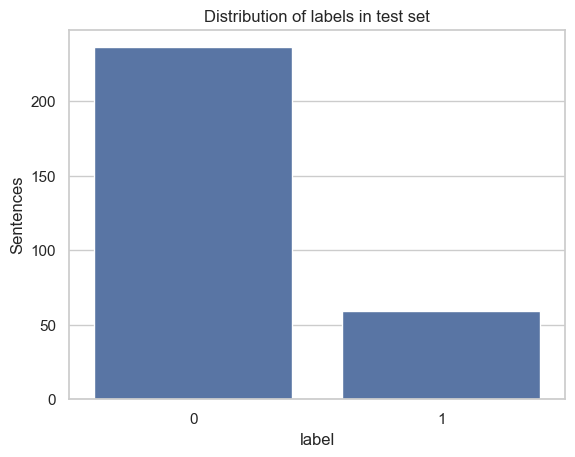

In [16]:
x1 = test_df['label'].value_counts()
sns.barplot(x1)
sns.set(style="whitegrid")
plt.title('Distribution of labels in test set')
plt.gca().set_ylabel('Sentences')
plt.show()

### FEATURE ENGINEERING

**1. NER**

In [17]:
def get_ner(text):
    ner_list = []
    # Annotate the text using stanza
    doc = nlp(text)

    for sentence in doc.sentences:
        for entity in sentence.ents:
            if entity.type == 'PERSON':
                ner_list.append(entity.text)

    return ner_list

# Example usage
text = "Barack Obama was the 44th doctor of the United States."
print(get_ner(text))

['Barack Obama']


In [18]:
# check if a named entity is present in the sentence
def named_entity_present(sentence):
    ner_list = get_ner(sentence)
    if len(ner_list) > 0:
        return 1
    else:
        return 0

**2. Similarity Features**

In [19]:
# A helper function to get the similar words and similarity score
# The function takes tokens of sentence as input and if its not a stop word, get its similarity with synsets of STEM.
stop_words = set(stopwords.words('english'))
stop_words |= set(["help","try", "work", "process", "support", "job"] )
def word_similarity(tokens, syns, field):    
    if field in ['engineering', 'technology']:
        score_threshold = 0.5
    else:
        score_threshold = 0.2
    sim_words = 0
    for token in tokens:
        if token not in stop_words:
            try:
                syns_word = wordnet.synsets(token) 
                score = syns_word[0].path_similarity(syns[0])
                if score >= score_threshold:
                    sim_words += 1
            except: 
                score = 0
    
    return sim_words

In [20]:
# Functions to create columns for similarity based on all STEM fields
syns_bio = wordnet.synsets(lemmatizer.lemmatize("biology"))
syns_maths = wordnet.synsets(lemmatizer.lemmatize("mathematics")) 
syns_tech = wordnet.synsets(lemmatizer.lemmatize("technology"))
syns_eng = wordnet.synsets(lemmatizer.lemmatize("engineering"))
syns_chem = wordnet.synsets(lemmatizer.lemmatize("chemistry"))
syns_phy = wordnet.synsets(lemmatizer.lemmatize("physics"))
syns_sci = wordnet.synsets(lemmatizer.lemmatize("science"))

**3. Medical Word Count**

In [21]:
# Load the medical specialization text file and create a list
medical_list = []
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/medical_specialities.txt', 'r') as medical_fields:
    for line in medical_fields.readlines():
        special_field = line.rstrip('\n')
        special_field = re.sub("\W"," ", special_field )
#         print(special_field)
        medical_list += special_field.split()
medical_list = list(set(medical_list))  
medical_list = [x.lower() for x in medical_list]
print(medical_list)

['adolescent', 'clinical', 'gastroenterology', 'endocrinology', 'electrophysiology', 'reconstructive', 'genetic', 'neuropathology', 'rheumatology', 'surgical', 'hematology', 'chemical', 'dermatology', 'retina', 'neurodevelopmental', 'disease', 'oncology', 'health', 'biochemical', 'cardiothoracic', 'administrative', 'genitourinary', 'occupational', 'renal', 'musculoskeletal', 'dermatopathology', 'failure', 'pulmonology', 'retardation', 'pathology', 'transplant', 'developmental', 'metabolism', 'cytopathology', 'oncology', 'critical', 'emergency', 'endocrinologists', 'ophthalmology', 'addiction', 'chest', 'psychiatric', 'strabismus', 'sports', 'dermatology', 'anterior', 'care', 'reproductive', 'behavioral', 'injury', 'urology', 'perinatal', 'banking', 'ocular', 'diabetes', 'medicine', 'hepatology', 'pediatric', 'sports', 'surgery', 'preventive', 'segment', 'hematology', 'and', 'imaging', 'nephrology', 'cardiac', 'endocrinology', 'infectious', 'hospice', 'anesthesiology', 'procedural', 'ad

In [22]:
# A helper function to get medical words
def check_medical_words(tokens):
    for token in tokens:
        if token not in stop_words and token in [x.lower() for x in medical_list]:
            return 1
        
    return 0

**4. Sentiment Polarity and Subjectivity**

In [23]:
# A helper function to get polarity and subjectivity of the sentence using TexBlob
def get_sentiment(sentence):
    sentiments =TextBlob(sentence).sentiment
    polarity = sentiments.polarity
    subjectivity = sentiments.subjectivity
    return polarity, subjectivity

**5. POS Tag Count**

In [24]:
# A helper function to get the count of POS tags of the sentence
def count_pos_tags(tokens):
    token_pos = pos_tag(tokens)
    count = Counter(tag for word,tag in token_pos)
    interjections =  count['UH']
    nouns = count['NN'] + count['NNS'] + count['NNP'] + count['NNPS']
    adverb = count['RB'] + count['RBS'] + count['RBR']
    verb = count['VB'] + count['VBD'] + count['VBG'] + count['VBN']
    determiner = count['DT']
    pronoun = count['PRP']
    adjetive = count['JJ'] + count['JJR'] + count['JJS']
    preposition = count['IN']
    return interjections, nouns, adverb, verb, determiner, pronoun, adjetive,preposition

In [25]:
def pos_tag_extraction(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

**6. Word Embeddings**

In [26]:
# Load the w2v dict from pickle file
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/pickle/embeddings06122024.pickle', 'rb') as w2v_file:
    w2v_dict = pickle.load(w2v_file)

In [27]:
print("length of word embeddings: ", len(w2v_dict.keys()))

length of word embeddings:  4762


In [28]:
# Get the vectors for the essay
def vectorizer(sequence):
    vect = []
    numw = 0
    for w in sequence: 
        try :
            if numw == 0:
                vect = w2v_dict[w]
            else:
                vect = np.add(vect, w2v_dict[w])
            numw += 1
        except Exception as e:
            pass

    return vect/ numw 

In [29]:
# Function to split text into words
def split_into_words(text):
    return text.split()

**7. Unigrams**

In [30]:
# Define the vectorizer
unigram_vect = CountVectorizer(ngram_range=(1, 1), min_df=2, stop_words = 'english')

**WRAPPER**

In [31]:
# Wrapper function for feature engineering
def feature_engineering(original_dataset):

    dataset = original_dataset.copy()
    # create a new column with sentence tokens
    dataset['tokens'] = dataset['sentence'].apply(word_tokenize)
    # 1. Similarity features
    # biology
    dataset['bio_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_bio,'biology',)) 
    # chemistry
    dataset['chem_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_chem,'chemistry',))
    # physics
    dataset['phy_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_phy,'physics',))
    # mathematics
    dataset['math_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_maths,'mathematics',))
    # technology
    dataset['tech_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_tech,'technology',))
    # engineering
    dataset['eng_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_eng,'engineering',))
    
    # medical terms
    dataset['medical_terms'] = dataset['tokens'].apply(check_medical_words)
    
    # polarity and subjectivity
    dataset['polarity'], dataset['subjectivity'] = zip(*dataset['sentence'].apply(get_sentiment))
    
    # named entity recognition
    dataset['ner'] = dataset['sentence'].apply(named_entity_present)
    
    # pos tag count
    dataset = pos_tag_extraction(dataset, 'tokens', count_pos_tags, ['interjections', 'nouns', 'adverb', 'verb', 'determiner', 'pronoun', 'adjetive','preposition'])
    
    # labels
    data_labels = dataset['label']
    # X
    data_x = dataset.drop(columns='label')

    
    # vectorize all the essays
    vect_arr = data_x.tokens.apply(vectorizer)
    for index in range(0, len(vect_arr)):
        i = 0
        for item in vect_arr[index]:
            column_name= "embedding" + str(i)
            data_x.loc[index, column_name] = item
            i +=1
    
    return data_x,data_labels
    

In [32]:
X_train, y_train = feature_engineering(training_df)

In [33]:
X_train.shape

(2645, 121)

In [34]:
y_train = y_train.astype('int')

In [35]:
X_test, y_test = feature_engineering(test_df)

In [36]:
X_test.shape

(295, 121)

In [37]:
y_test = y_test.astype('int')

**Calculate Unigram features for both train and test set**

In [38]:
X_train.shape

(2645, 121)

In [39]:
X_test.shape

(295, 121)

In [107]:
X_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/Aspirational/using_original/saved_feature_engineered_dataset/exp_2/X_train_final.csv", index=False)
X_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/Aspirational/using_original/saved_feature_engineered_dataset/exp_2/X_test_final.csv", index=False)
y_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/Aspirational/using_original/saved_feature_engineered_dataset/exp_2/y_train.csv", index=False)
y_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/Aspirational/using_original/saved_feature_engineered_dataset/exp_2/y_test.csv", index=False)


In [41]:
# Unigrams for training set
unigram_matrix = unigram_vect.fit_transform(X_train['sentence'])
unigrams = pd.DataFrame(unigram_matrix.toarray())
print("Shape of the unigram df for train : ",unigrams.shape)
unigrams = unigrams.reset_index(drop=True)

Shape of the unigram df for train :  (2645, 1707)


In [42]:
X_train_final = pd.concat([X_train, unigrams], axis = 1)

In [43]:
X_train_final.columns = X_train_final.columns.astype(str)

In [44]:
X_train_final.shape

(2645, 1828)

In [45]:
unigram_matrix_test = unigram_vect.transform(X_test['sentence'])
unigrams_test = pd.DataFrame(unigram_matrix_test.toarray())
unigrams_test = unigrams_test.reset_index(drop=True)
print("Test unigram df shape : ",unigrams_test.shape)

Test unigram df shape :  (295, 1707)


In [46]:
X_test_final = pd.concat([X_test, unigrams_test], axis = 1)
X_test_final.shape

(295, 1828)

In [47]:
X_test_final.columns = X_test_final.columns.astype(str)

In [104]:
X_test_final.shape

(295, 1828)

In [49]:
for i in range(0, len(X_train_final.columns)):
    print('{} ---- {}'.format(i, X_train_final.columns[i]))

0 ---- sentence
1 ---- phrase
2 ---- tokens
3 ---- bio_sim_words
4 ---- chem_sim_words
5 ---- phy_sim_words
6 ---- math_sim_words
7 ---- tech_sim_words
8 ---- eng_sim_words
9 ---- medical_terms
10 ---- polarity
11 ---- subjectivity
12 ---- ner
13 ---- interjections
14 ---- nouns
15 ---- adverb
16 ---- verb
17 ---- determiner
18 ---- pronoun
19 ---- adjetive
20 ---- preposition
21 ---- embedding0
22 ---- embedding1
23 ---- embedding2
24 ---- embedding3
25 ---- embedding4
26 ---- embedding5
27 ---- embedding6
28 ---- embedding7
29 ---- embedding8
30 ---- embedding9
31 ---- embedding10
32 ---- embedding11
33 ---- embedding12
34 ---- embedding13
35 ---- embedding14
36 ---- embedding15
37 ---- embedding16
38 ---- embedding17
39 ---- embedding18
40 ---- embedding19
41 ---- embedding20
42 ---- embedding21
43 ---- embedding22
44 ---- embedding23
45 ---- embedding24
46 ---- embedding25
47 ---- embedding26
48 ---- embedding27
49 ---- embedding28
50 ---- embedding29
51 ---- embedding30
52 ---- em

### Model 1: Unigrams, POS Tag Count, Sentiment Polarity, Subjectivity

In [50]:
X_train_final

,sentence,phrase,tokens,bio_sim_words,chem_sim_words,phy_sim_words,math_sim_words,tech_sim_words,eng_sim_words,medical_terms,...,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706
0,i have no specific direction in my life other than the general goal i have always had since i knew how to talk.,"['I am here because I want to do better in my OCHEM class.', 'I want to learn new things that are outside of my comfort zone.']","[i, have, no, specific, direction, in, my, life, other, than, the, general, goal, i, have, always, had, since, i, knew, how, to, talk, .]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,being here has many different meanings and perspectives.,"['I am here in this class to get my degree, but I am here at this school to better my life.']","[being, here, has, many, different, meanings, and, perspectives, .]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"i am intrigued by this career because i grew up with family who died due to heart conditions, therefore i want to be able to understand and form conclusions on my own that way i can comprehend the cause of their deaths.",['a degree in Cell and Molecular Biology'],"[i, am, intrigued, by, this, career, because, i, grew, up, with, family, who, died, due, to, heart, conditions, ,, therefore, i, want, to, be, able, to, understand, and, form, conclusions, on, my, own, that, way, i, can, comprehend, the, cause, of, their, deaths, .]",0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,"higher education for me is a segway into the job field, without it would make getting a job in the future that much more difficult.",['All of this has lead me to pursue a degree in Mechanical Engineering'],"[higher, education, for, me, is, a, segway, into, the, job, field, ,, without, it, would, make, getting, a, job, in, the, future, that, much, more, difficult, .]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"physics 2 is difficult but instead of giving up like before, my attitude includes ambition and determination.",['The real reason I am actually here is to learn how to be a better physical therapist in the future by understanding the foundations of biomechanics through physics.'],"[physics, 2, is, difficult, but, instead, of, giving, up, like, before, ,, my, attitude, includes, ambition, and, determination, .]",1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2640,this means that i am going to need to understand some of the material that i learn in physics for my specific major.,['planning on declaring a concentration in zoology by the end of this semester'],"[this, means, that, i, am, going, to, need, to, understand, some, of, the, material, that, i, learn, in, physics, for, my, specific, major, .]",1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2641,"we know some and we don't know a lot which is quite interesting, in biology we know a lot as well as anatomy but what about the universe?","[""I'm here at SFSU because I want to do something I enjoy doing and make it into a career."", 'To learn and grow from the things that spark my interest.']","[we, know, some, and, we, do, n't, know, a, lot, which, is, quite, interesting, ,, in, biology, we, know, a, lot, as, well, as, anatomy, but, what, about, the, universe, ?]",2,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2642,"although i am interested in science now, her pushing me to do robotics did not affect that choice.",['I eventually decided to quit this job to fulltime pursue my undergraduate degree in microbiology.'],"[although, i, am, interested, in, science, now, ,, her, pushing, me, to, do, robotics, did, not, affect, that, choice, .]",1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2643,i am here because i am required to take this class for my major.,"['Hopefully taking all these integrated math classes for my major, I can be very wellrounded in math, although it takes me a While to compute problems, at least the answers will be right.']","[i, am, here, because, i, am, required, to, take, this, class, for, my, m

In [142]:
X_train_final.shape

(1058, 1036)

In [51]:
X_train_model_1 = X_train_final.iloc[:,np.r_[10:12,13:21,121:1828]]

In [52]:
X_train_model_1.shape

(2645, 1717)

In [53]:
X_train_model_1.head(2)

,polarity,subjectivity,interjections,nouns,adverb,verb,determiner,pronoun,adjetive,preposition,...,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706
0,-0.025,0.333333,0,6,1,3,2,0,3,3,...,0,0,0,0,0,0,0,0,0,0
1,0.250,0.550000,0,2,1,1,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
X_test_model_1 = X_test_final.iloc[:,np.r_[10:12,13:21,121:1828]]

In [55]:
X_test_model_1.shape

(295, 1717)

In [56]:
model_1_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_1_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_1,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_1), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.526
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9179    0.8051    0.8578       236
           1     0.4773    0.7119    0.5714        59

    accuracy                         0.7864       295
   macro avg     0.6976    0.7585    0.7146       295
weighted avg     0.8298    0.7864    0.8005       295



In [57]:
lr_model_1 = LogisticRegression(random_state=18, 
                                solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], 
                                class_weight='balanced').fit(X_train_model_1, y_train)
y_lr = lr_model_1.predict(X_test_model_1)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 190, False Positive: 46, False Negative: 17, True Positive: 42
--------------------------------------------------------------------------------
[[190  46]
 [ 17  42]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       236
           1       0.48      0.71      0.57        59

    accuracy                           0.79       295
   macro avg       0.70      0.76      0.71       295
weighted avg       0.83      0.79      0.80       295



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.93 | 0.85 | 0.89 | 117 |
| Class 1 |0.51 | 0.72 | 0.60 | 25 |
| Macro Average Score | 0.72 | 0.79 | 0.75 | 142|

### Model 2: All Features

In [58]:
# X_train_model_2 = X_train_final.iloc[:,np.r_[3:1113]]
X_train_model_2 = X_train_final.iloc[:, np.r_[3:1828]]

In [59]:
X_train_model_2.shape

(2645, 1825)

In [61]:
X_test_model_2 = X_test_final.iloc[:,np.r_[3:1828]]

In [62]:
X_test_model_2.shape

(295, 1825)

In [63]:
# from sklearn.preprocessing import StandardScaler
# # Updated pipeline with scaling
# model_2_pipeline = Pipeline([
#     # ('scaler', StandardScaler()),  # Feature scaling
#     ('clf', LogisticRegression(class_weight='balanced', random_state=18)),
# ])

# # Expanded parameter grid
# parameters = {
#     'clf__C': [0.0001, 0.001, 0.009, 0.01, 0.1, 1, 5, 10],
#     'clf__penalty': ["l2", "elasticnet"],  # Consider adding "elasticnet" if you decide to use it
#     'clf__solver': ['liblinear'],  # Include saga for larger datasets
# }

# # Using GridSearchCV with additional scoring
# grid_search = GridSearchCV(model_2_pipeline, parameters, scoring="f1", cv=10, n_jobs=-1, verbose=1)

# # Fitting the model
# grid_search.fit(X_train_model_2, y_train)

# # Best score and parameters
# print("Best score: %0.3f" % grid_search.best_score_)
# print("Best parameters set:")
# best_parameters = grid_search.best_estimator_.get_params()

# for param_name in sorted(parameters.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

# # Classification report on test set
# print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_2), digits=4))

model_2_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2", "elasticnet"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_2_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_2,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_2), digits=4))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best score: 0.535
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9447    0.7966    0.8644       236
           1     0.5000    0.8136    0.6194        59

    accuracy                         0.8000       295
   macro avg     0.7224    0.8051    0.7419       295
weighted avg     0.8558    0.8000    0.8154       295



In [64]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
# Fit the logistic regression model
lr_model_2 = LogisticRegression(random_state=18, 
                                 solver=best_parameters['clf__solver'], 
                                 C=best_parameters['clf__C'], 
                                 penalty=best_parameters['clf__penalty'], 
                                 class_weight='balanced').fit(X_train_model_2, y_train)

# Get predicted probabilities for the positive class
y_proba = lr_model_2.predict_proba(X_test_model_2)[:, 1]

# Set an initial threshold (0.5 is common, but can be adjusted)
threshold = 0.5
y_lr_adjusted = (y_proba >= threshold).astype(int)

# Compute confusion matrix and classification report
tn, fp, fn, tp = confusion_matrix(y_test, y_lr_adjusted).ravel()
print('Logistic Regression Classifier')
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr_adjusted))
print('-' * 80)
print(classification_report(y_test, y_lr_adjusted))

# Evaluate different thresholds
thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
    y_lr_temp = (y_proba >= threshold).astype(int)
    temp_precision = precision_score(y_test, y_lr_temp)
    temp_recall = recall_score(y_test, y_lr_temp)
    print(f"Threshold: {threshold:.1f}, Precision: {temp_precision:.4f}, Recall: {temp_recall:.4f}")

Logistic Regression Classifier
True Negative: 188, False Positive: 48, False Negative: 11, True Positive: 48
--------------------------------------------------------------------------------
[[188  48]
 [ 11  48]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       236
           1       0.50      0.81      0.62        59

    accuracy                           0.80       295
   macro avg       0.72      0.81      0.74       295
weighted avg       0.86      0.80      0.82       295

Threshold: 0.1, Precision: 0.2042, Recall: 1.0000
Threshold: 0.2, Precision: 0.2511, Recall: 1.0000
Threshold: 0.3, Precision: 0.3333, Recall: 0.9661
Threshold: 0.4, Precision: 0.4252, Recall: 0.9153
Threshold: 0.5, Precision: 0.5000, Recall: 0.8136
Threshold: 0.6, Precision: 0.5556, Recall: 0.5932
Threshold: 0.7, Precision: 0.6667, Recall: 0.3729
Threshold: 0.8, Precision: 0.

In [65]:
lr_model_2 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_2, y_train)
y_lr = lr_model_2.predict(X_test_model_2)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 188, False Positive: 48, False Negative: 11, True Positive: 48
--------------------------------------------------------------------------------
[[188  48]
 [ 11  48]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       236
           1       0.50      0.81      0.62        59

    accuracy                           0.80       295
   macro avg       0.72      0.81      0.74       295
weighted avg       0.86      0.80      0.82       295



In [66]:
NameOfVariables = X_train_model_2.columns.values
Var_coef = zip(lr_model_2.coef_[0,:],NameOfVariables)
sorted_coef_val = sorted(Var_coef)
for item in sorted_coef_val:
    print(item[1],'--- Value:',item[0])

embedding87 --- Value: -0.751241450552615
755 --- Value: -0.6074656649162681
embedding94 --- Value: -0.5474846190093541
171 --- Value: -0.5095938503916275
embedding83 --- Value: -0.47378732716968314
1310 --- Value: -0.4598287809657892
424 --- Value: -0.4518160948831221
754 --- Value: -0.42466586213625307
740 --- Value: -0.40389646092884474
embedding61 --- Value: -0.3796793957552409
135 --- Value: -0.37035580522349154
1115 --- Value: -0.32622236521459874
1554 --- Value: -0.32013060692917134
embedding88 --- Value: -0.3198685067827819
590 --- Value: -0.3170198457831174
embedding90 --- Value: -0.30705531868640007
360 --- Value: -0.3033069284752465
695 --- Value: -0.2963617365011906
embedding44 --- Value: -0.2928101521978722
1089 --- Value: -0.27642898524969384
1450 --- Value: -0.27408551821683425
1490 --- Value: -0.2657313808477706
510 --- Value: -0.26297361291100785
embedding45 --- Value: -0.26225190865233783
653 --- Value: -0.2602765864424637
1570 --- Value: -0.2574949544652919
266 --- V

| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.97 | 0.88 | 0.92 | 117 |
| Class 1 |0.61 | 0.88 | 0.72 | 25 |
| Macro Average Score | 0.79 | 0.88 | 0.82 | 142|

### Model 3: Without Unigrams

In [67]:
X_train_model_3 = X_train_final.iloc[:,np.r_[3:121]]

In [68]:
X_train_model_3.shape

(2645, 118)

In [69]:
X_test_model_3 = X_test_final.iloc[:,np.r_[3:121]]

In [70]:
X_test_model_3.shape

(295, 118)

In [71]:
model_3_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.0001, 0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2", "elasticnet"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_3_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_3,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_3), digits=4))

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.507
Best parameters set:
	clf__C: 10
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9337    0.7161    0.8106       236
           1     0.4123    0.7966    0.5434        59

    accuracy                         0.7322       295
   macro avg     0.6730    0.7564    0.6770       295
weighted avg     0.8294    0.7322    0.7571       295



In [72]:
lr_model_3 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_3, y_train)
y_lr = lr_model_3.predict(X_test_model_3)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 169, False Positive: 67, False Negative: 12, True Positive: 47
--------------------------------------------------------------------------------
[[169  67]
 [ 12  47]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.72      0.81       236
           1       0.41      0.80      0.54        59

    accuracy                           0.73       295
   macro avg       0.67      0.76      0.68       295
weighted avg       0.83      0.73      0.76       295



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.99 | 0.82 | 0.90 | 117 |
| Class 1 |0.53 | 0.96 | 0.69 | 25 |
| Macro Average Score | 0.76 | 0.89 | 0.79 | 142|

### Model 4: Without Embeddings

In [73]:
X_train_model_4 = X_train_final.iloc[:,np.r_[3:21,121:1828]]

In [74]:
X_train_model_4.shape

(2645, 1725)

In [75]:
X_test_model_4 = X_test_final.iloc[:,np.r_[3:21,121:1828]]

In [76]:
X_test_model_4.shape

(295, 1725)

In [77]:
model_4_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
              'clf__C': [0.0001, 0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2", "elasticnet"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_4_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_4,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_4), digits=4))

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.520
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9223    0.8051    0.8597       236
           1     0.4831    0.7288    0.5811        59

    accuracy                         0.7898       295
   macro avg     0.7027    0.7669    0.7204       295
weighted avg     0.8345    0.7898    0.8040       295



In [78]:
lr_model_4 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_4, y_train)
y_lr = lr_model_4.predict(X_test_model_4)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 190, False Positive: 46, False Negative: 16, True Positive: 43
--------------------------------------------------------------------------------
[[190  46]
 [ 16  43]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       236
           1       0.48      0.73      0.58        59

    accuracy                           0.79       295
   macro avg       0.70      0.77      0.72       295
weighted avg       0.83      0.79      0.80       295



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.94 | 0.89 | 0.91 | 117 |
| Class 1 |0.58 | 0.72 | 0.64 | 25 |
| Macro Average Score | 0.76 | 0.80 | 0.78 | 142|

### Model 5: Without POS Tag Count

In [79]:
X_train_model_5 = X_train_final.iloc[:,np.r_[3:13,21:1828]]

In [80]:
X_train_model_5.shape

(2645, 1817)

In [81]:
X_test_model_5 = X_test_final.iloc[:,np.r_[3:13,21:1828]]

In [82]:
X_test_model_5.shape

(295, 1817)

In [83]:
model_5_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_5_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_5,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_5), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.530
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       236
           1       0.49      0.78      0.61        59

    accuracy                           0.80       295
   macro avg       0.72      0.79      0.73       295
weighted avg       0.85      0.80      0.81       295



In [84]:
lr_model_5 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_5, y_train)
y_lr = lr_model_5.predict(X_test_model_5)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 189, False Positive: 47, False Negative: 13, True Positive: 46
--------------------------------------------------------------------------------
[[189  47]
 [ 13  46]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       236
           1       0.49      0.78      0.61        59

    accuracy                           0.80       295
   macro avg       0.72      0.79      0.73       295
weighted avg       0.85      0.80      0.81       295



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.96 | 0.86 | 0.91 | 117 |
| Class 1 |0.57 | 0.84 | 0.68 | 25 |
| Macro Average Score | 0.76 | 0.85 | 0.79 | 142|

In [85]:
NameOfVariables = X_train_model_5.columns.values
Var_coef = zip(lr_model_5.coef_[0,:],NameOfVariables)
sorted_coef_val = sorted(Var_coef)
for item in sorted_coef_val:
    print(item[1],'--- Value:',item[0])

embedding87 --- Value: -0.7328537172727193
755 --- Value: -0.5761428127342885
embedding94 --- Value: -0.5560546968466478
171 --- Value: -0.4834516523741001
embedding83 --- Value: -0.4752858387635073
1310 --- Value: -0.46607419407541
754 --- Value: -0.4425637009329705
424 --- Value: -0.4249935906263951
740 --- Value: -0.37842589154051126
embedding61 --- Value: -0.3680040995183749
135 --- Value: -0.3441987700212645
1115 --- Value: -0.3263068194297412
embedding90 --- Value: -0.3231734642408516
590 --- Value: -0.315962648842536
1554 --- Value: -0.2990803153233366
embedding88 --- Value: -0.29633111746822877
embedding44 --- Value: -0.28499090143884676
266 --- Value: -0.2791829404396277
360 --- Value: -0.2773869783967503
embedding45 --- Value: -0.2752625779710122
embedding0 --- Value: -0.26909434279142747
1490 --- Value: -0.2679492880533129
653 --- Value: -0.2570778686834626
249 --- Value: -0.2565944250455532
1450 --- Value: -0.2565467407100673
embedding42 --- Value: -0.25323083096629684
510 

### Model 6: Without STEM Similarity

In [86]:
X_train_model_6 = X_train_final.iloc[:,np.r_[10:1828]]

In [87]:
X_train_model_6.shape

(2645, 1818)

In [88]:
X_test_model_6 = X_test_final.iloc[:,np.r_[10:1828]]

In [89]:
X_test_model_6.shape

(295, 1818)

In [90]:
model_6_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_6_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_6,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_6), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.536
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       236
           1       0.50      0.83      0.62        59

    accuracy                           0.80       295
   macro avg       0.72      0.81      0.74       295
weighted avg       0.86      0.80      0.82       295



In [91]:
lr_model_6 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_6, y_train)
y_lr = lr_model_6.predict(X_test_model_6)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 187, False Positive: 49, False Negative: 10, True Positive: 49
--------------------------------------------------------------------------------
[[187  49]
 [ 10  49]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       236
           1       0.50      0.83      0.62        59

    accuracy                           0.80       295
   macro avg       0.72      0.81      0.74       295
weighted avg       0.86      0.80      0.82       295



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.97 | 0.87 | 0.92 | 117 |
| Class 1 |0.59 | 0.88 | 0.71 | 25 |
| Macro Average Score | 0.78 | 0.88 | 0.81 | 142|

### Model 7: Without Sentiment Features

In [92]:
X_train_model_7 = X_train_final.iloc[:,np.r_[3:10,12:1828]]

In [93]:
X_train_model_7.shape

(2645, 1823)

In [94]:
X_test_model_7 = X_test_final.iloc[:,np.r_[3:10,12:1828]]

In [95]:
X_test_model_7.shape

(295, 1823)

In [96]:
model_7_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_7_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_7,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_7), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.530
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       236
           1       0.49      0.80      0.61        59

    accuracy                           0.79       295
   macro avg       0.71      0.79      0.73       295
weighted avg       0.85      0.79      0.81       295



In [97]:
lr_model_7 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_7, y_train)
y_lr = lr_model_7.predict(X_test_model_7)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 187, False Positive: 49, False Negative: 12, True Positive: 47
--------------------------------------------------------------------------------
[[187  49]
 [ 12  47]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       236
           1       0.49      0.80      0.61        59

    accuracy                           0.79       295
   macro avg       0.71      0.79      0.73       295
weighted avg       0.85      0.79      0.81       295



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.94 | 0.88 | 0.91 | 117 |
| Class 1 |0.58 | 0.76 | 0.66 | 25 |
| Macro Average Score | 0.76 | 0.82 | 0.78 | 142|

### Model 8: Without NER

In [98]:
X_train_model_8 = X_train_final.iloc[:,np.r_[3:12,13:1828]]

In [99]:
X_train_model_8.shape

(2645, 1824)

In [100]:
X_test_model_8 = X_test_final.iloc[:,np.r_[3:12,13:1828]]

In [101]:
X_test_model_8.shape

(295, 1824)

In [102]:
model_8_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_8_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_8,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_8), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.535
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       236
           1       0.50      0.81      0.62        59

    accuracy                           0.80       295
   macro avg       0.72      0.81      0.74       295
weighted avg       0.86      0.80      0.82       295



In [103]:
lr_model_8 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_8, y_train)
y_lr = lr_model_8.predict(X_test_model_8)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 188, False Positive: 48, False Negative: 11, True Positive: 48
--------------------------------------------------------------------------------
[[188  48]
 [ 11  48]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       236
           1       0.50      0.81      0.62        59

    accuracy                           0.80       295
   macro avg       0.72      0.81      0.74       295
weighted avg       0.86      0.80      0.82       295



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.96 | 0.86 | 0.91 | 117 |
| Class 1 |0.57 | 0.84 | 0.68 | 25 |
| Macro Average Score | 0.76 | 0.85 | 0.79 | 142|

### Final Summary

| S.No|Features| Precision | Recall | F1 |
| :-:| :-- | :-: |:-: | :-: |
| 1 |Embeddings + POS Tag Count + Sentiment (Polarity and Subjectivity) + STEM Similarity + NER| 0.76 | 0.89 | 0.79 |
| 2 |Unigrams + POS Tag Count + Sentiment (Polarity and Subjectivity) + STEM Similarity + NER  |0.76 | 0.80 | 0.78 |
| 3 |Embeddings + Unigrams + Sentiment (Polarity and Subjectivity) + STEM Similarity + NER | 0.76 | 0.85 | 0.79 |
| 4 |**Embeddings + Unigrams + Sentiment (Polarity and Subjectivity) + NER + POS Tag Count** | **0.78** | **0.88** | **0.81**|
| 5 |Embeddings + Unigrams + STEM Similarity + NER + POS Tag Count | 0.76 | 0.82 | 0.78|
| 6 |Embeddings + Unigrams + STEM Similarity + POS Tag Count + Sentiment (Polarity and Subjectivity) | 0.76 | 0.85 | 0.79|